# Burrau: preliminary experiments

<ul id="top">
<li><a href="#Loading-packages"> 
             Loading Packages</a></li>
    
<li><a href="#Computer-properties"> 
             Computer properties</a></li>  

<li><a href="#Initial-value-problem:-Burrau">
             Initial value problem: Burrau</a></li>

<li><a href="#Test-solution">
             Test solution</a></li>
             
<li><a href="#Float64-Computations-(Second-Order-ODE)">
              Float64 Computations (Second Order ODE)</a></li>

<li><a href="#Float128-Computations-(General ODE Problem)">
              Float128 Computations (General ODE Problem)</a></li>

<li><a href="#Float128-Computations-(Second-Order-ODE)">
              Float128 Computations (Second Order ODE)</a></li>

<li><a href="#Error-in-energy">
             Error in energy</a></li> 

</ul>  

## Loading packages

In [17]:
using OrdinaryDiffEq,DiffEqDevTools
using IRKGaussLegendre
using Plots, LinearAlgebra
using Dates, LaTeXStrings
using JLD2, FileIO
using RecursiveArrayTools

In [2]:
#plotly()

<a href="#top">Back to the top</a>

## Computer properties

In [6]:
#export JULIA_NUM_THREADS=2
Threads.nthreads()

1

In [4]:
#;cat /proc/cpuinfo # on Linux machines

In [7]:
using Hwloc
Hwloc.num_physical_cores()

2

<a href="#top">Back to the top</a>

## Initial value problem: Burrau

In [8]:
setprecision(BigFloat, 108);
include("../ODEProblems/Nbody.jl")
include("../ODEProblems/InitialBurrau.jl")

t0=0.0
t1=63.0
t1=10.0    # !!!!!!!!

u064,Gm64 =InitialBurrau(Float64)
lpp=Gm64
tspan64=(t0,t1)
prob64 = ODEProblem(NbodyODE!,u064,tspan64,Gm64);

u0128,Gm128=InitialBurrau(BigFloat)
tspan128=(BigFloat(t0),BigFloat(t1))
prob128 = ODEProblem(NbodyODE!,u0128,tspan128,Gm128,;lpp=lpp)

q064=u064[2,:,:]
v064=u064[1,:,:]
probdyn64 = DynamicalODEProblem(NbodyODEq!,NbodyODEv!,q064,v064,tspan64,Gm64);
prob2nd64 = SecondOrderODEProblem(NbodyODE2nd!,v064,q064,tspan64,Gm64);


q0128=u0128[2,:,:]
v0128=u0128[1,:,:]
probdyn128 = DynamicalODEProblem(NbodyODEq!,NbodyODEv!,q0128,v0128,tspan128,Gm128);
prob2nd128 = SecondOrderODEProblem(NbodyODE2nd!,v0128,q0128,tspan128,Gm128);


mysaveat=10
vsaveat=0.1
(typeof(u064),typeof(Gm64),typeof(tspan64),typeof(u0128),typeof(Gm128),typeof(tspan128))

(Array{Float64,3}, Array{Float64,1}, Tuple{Float64,Float64}, Array{BigFloat,3}, Array{BigFloat,1}, Tuple{BigFloat,BigFloat})

<a href="#top">Back to the top</a>

## Test solution

In [11]:
setprecision(BigFloat, 256)

#sol =solve(prob128,Vern9(),save_everystep=false, abstol=1e-32,reltol=1e-32);
#@save "./Data/burrau_test_sol.jld2" sol

@load "./Data/burrau_test_sol.jld2" sol
test_sol = TestSolution(sol)
sol.destats

u0256,Gm256=InitialBurrau(BigFloat)

E0=NbodyEnergy(u0256,Gm256)

(Float32(sol.t[end]),Float32(NbodyEnergy(sol.u[end],Gm256)/E0-1))

(63.0f0, 1.297102f-30)

<a href="#top">Back to the top</a>

## Float64 Computations (Second Order ODE)

### Vern9

In [12]:
sol9 =solve(probdyn64,Vern9(), abstol=1e-12,reltol=1e-12);
sol9.destats

DiffEqBase.DEStats
Number of function 1 evaluations:                  10258
Number of function 2 evaluations:                  0
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of rootfind condition calls:                0
Number of accepted steps:                          502
Number of rejected steps:                          139

### DPRK12

In [13]:
sol8 =solve(prob2nd64,DPRKN12(),abstol=1e-12,reltol=1e-12);
sol8.destats

DiffEqBase.DEStats
Number of function 1 evaluations:                  6939
Number of function 2 evaluations:                  409
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of rootfind condition calls:                0
Number of accepted steps:                          302
Number of rejected steps:                          106

### IRKGL16 

In [14]:
sol1 = solve(probdyn64,IRKGL16(), reltol=1e-12, abstol=1e-12,adaptive=true, mixed_precision=false)
sol1.destats

DiffEqBase.DEStats
Number of function 1 evaluations:                  8403
Number of function 2 evaluations:                  0
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of rootfind condition calls:                0
Number of accepted steps:                          156
Number of rejected steps:                          20

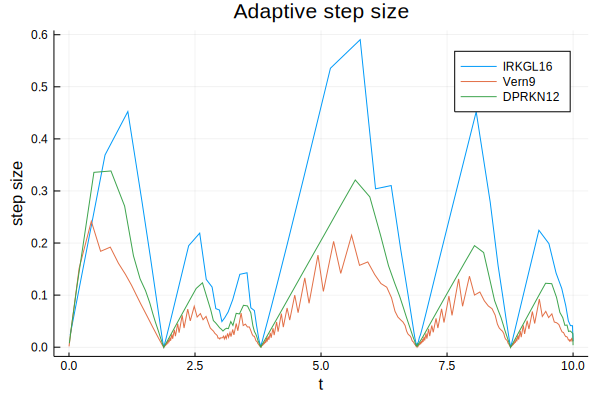

In [15]:
plot(xlabel="t", ylabel="step size",title="Adaptive step size")
steps1 =sol1.t[2:end]-sol1.t[1:end-1]
plot!(sol1.t[2:end],steps1, label="IRKGL16")
steps9 =sol9.t[2:end]-sol9.t[1:end-1]
plot!(sol9.t[2:end],steps9, label="Vern9")
steps8 =sol8.t[2:end]-sol8.t[1:end-1]
plot!(sol8.t[2:end],steps8, label="DPRKN12")

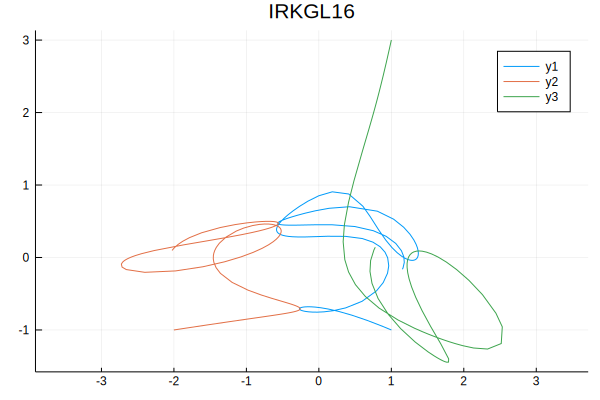

In [11]:
pl1 = plot(title="IRKGL16",aspect_ratio=1)

ulist = sol1.u[1:end]
tlist = sol1.t[1:end]

for j = 1:3
# sol=> q=u[1,.:,:] and  v=u[2,.:,:] !!!!!     
# xlist  = map(u->u[2,1,j], ulist11)     
# ylist  = map(u->u[2,2,j], ulist11) 
xlist  = map(u->u[1,1,j], ulist)     
ylist  = map(u->u[1,2,j], ulist)   
 pl1 = plot!(xlist,ylist) # label = bodylist[j])   
end  
plot(pl1)

### Energy Error

In [16]:
setprecision(BigFloat, 256)
u0256, Gm256 =InitialBurrau(BigFloat)

E0=NbodyEnergy(u0256,Gm256)

ΔE1 = map(x->NbodyEnergy2(BigFloat.(x),Gm256), sol1.u)./E0.-1
ΔE9 = map(x->NbodyEnergy2(BigFloat.(x),Gm256), sol9.u)./E0.-1
ΔE8 = map(x->NbodyEnergy(BigFloat.(x),Gm256), sol8.u)./E0.-1
#ΔE21 = map(x->NbodyEnergy(BigFloat.(vcat(x[2,:],x[1,:])),Gm128), sol21.u)./E0.-1
(Float32(maximum(abs.(ΔE1))),Float32(maximum(abs.(ΔE9))), Float32(maximum(abs.(ΔE8))))

(6.8836506f-13, 4.6843678f-11, 1.8394457f-12)

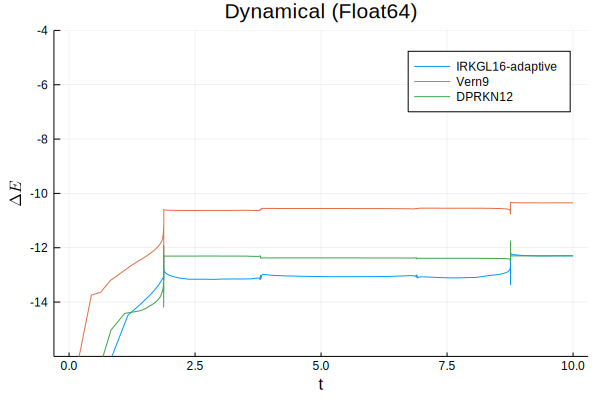

In [18]:
ylimit1=-16
ylimit2=-4
plot(title="Energy error", xlabel="t", ylabel=L"\Delta E")
plot!(sol1.t,log10.(abs.(ΔE1)), label="IRKGL16-adaptive",
     ylims=(ylimit1,ylimit2),)
plot!(sol9.t,log10.(abs.(ΔE9)), label="Vern9",
     ylims=(ylimit1,ylimit2),)
plot!(sol8.t,log10.(abs.(ΔE8)), label="DPRKN12",
     ylims=(ylimit1,ylimit2),)

<a href="#top">Back to the top</a>

## Float128 Computations (General ODE Problem)

In [19]:
setprecision(BigFloat, 108);

### Vern9

In [15]:
sol19 =solve(prob128,Vern9(),abstol=1e-20,reltol=1e-20);
sol19.destats

DiffEqBase.DEStats
Number of function 1 evaluations:                  66242
Number of function 2 evaluations:                  0
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of rootfind condition calls:                0
Number of accepted steps:                          4140
Number of rejected steps:                          0

### IRKGL16 

In [16]:
sol11 = solve(prob128,IRKGL16(), reltol=1e-20, abstol=1e-20, adaptive=true,mixed_precision=false)
sol11.destats

DiffEqBase.DEStats
Number of function 1 evaluations:                  56962
Number of function 2 evaluations:                  0
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of rootfind condition calls:                0
Number of accepted steps:                          471
Number of rejected steps:                          39

### IRKGL16 (Mixed-Precision)

In [17]:
sol12 = solve(prob128,IRKGL16(),reltol=1e-20, abstol=1e-20,adaptive=true,mixed_precision=true,low_prec_type=Float64)
sol12.destats

DiffEqBase.DEStats
Number of function 1 evaluations:                  21066
Number of function 2 evaluations:                  154644
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of rootfind condition calls:                0
Number of accepted steps:                          471
Number of rejected steps:                          39

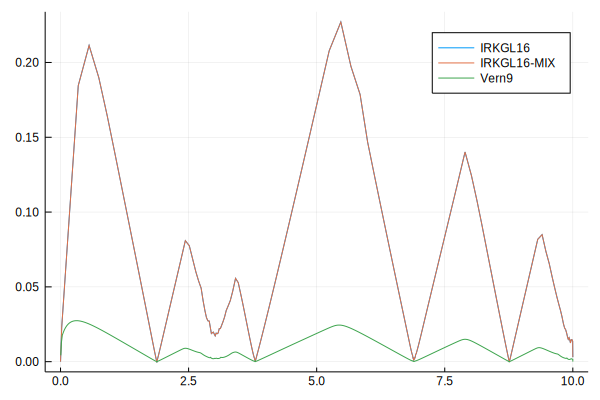

In [18]:
plot(xlabel="t", ylabel="step size",title="Adaptive step size")
steps11 =sol11.t[2:end]-sol11.t[1:end-1]
plot(sol11.t[2:end],steps11, label="IRKGL16")
steps12 =sol12.t[2:end]-sol12.t[1:end-1]
plot!(sol12.t[2:end],steps12, label="IRKGL16-MIX")
steps19 =sol19.t[2:end]-sol19.t[1:end-1]
plot!(sol19.t[2:end],steps19, label="Vern9")

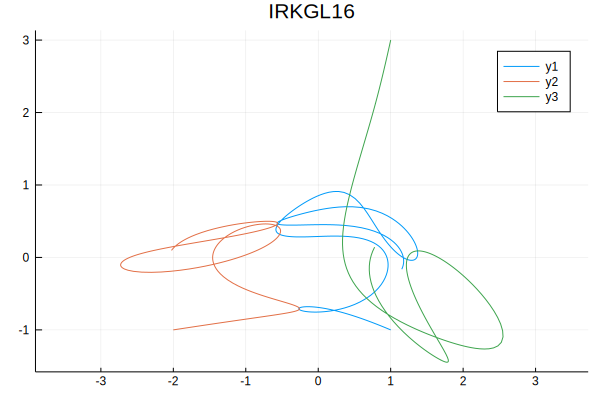

In [19]:
pl1 = plot(title="IRKGL16",aspect_ratio=1)

ulist11 = sol11.u[1:end]
tlist11 = sol11.t[1:end]

for j = 1:3
 xlist  = map(u->u[2,1,j], ulist11)     
 ylist  = map(u->u[2,2,j], ulist11)     
 pl1 = plot!(xlist,ylist) # label = bodylist[j])   
end  
plot(pl1)

<a href="#top">Back to the top</a>

## Float128 Computations (Second Order Problem)

In [20]:
setprecision(BigFloat, 108);

### Vern9

In [21]:
sol29 = solve(probdyn128,Vern9(), reltol=1e-20, abstol=1e-20)
sol29.destats

DiffEqBase.DEStats
Number of function 1 evaluations:                  75106
Number of function 2 evaluations:                  0
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of rootfind condition calls:                0
Number of accepted steps:                          3901
Number of rejected steps:                          793

### DPRKN12

In [22]:
sol28 = solve(prob2nd128,DPRKN12(), abstol=1e-20,reltol=1e-20);
sol28.destats

DiffEqBase.DEStats
Number of function 1 evaluations:                  24857
Number of function 2 evaluations:                  1463
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of rootfind condition calls:                0
Number of accepted steps:                          1449
Number of rejected steps:                          13

### IRKGL16 

In [23]:
sol21 = solve(probdyn128,IRKGL16(), reltol=1e-20, abstol=1e-20,adaptive=true, mixed_precision=false)
sol21.destats

DiffEqBase.DEStats
Number of function 1 evaluations:                  32687
Number of function 2 evaluations:                  0
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of rootfind condition calls:                0
Number of accepted steps:                          471
Number of rejected steps:                          39

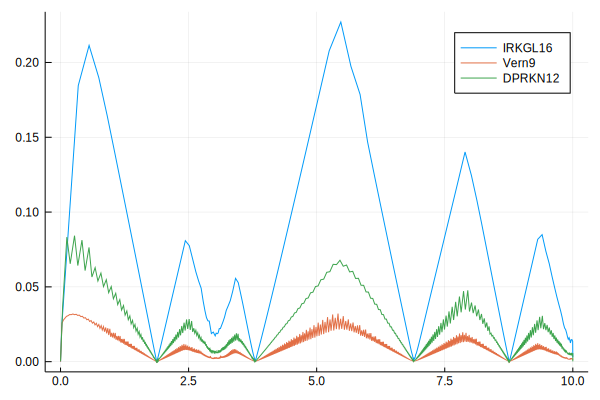

In [24]:
plot(xlabel="t", ylabel="step size",title="Adaptive step size")
steps21 =sol21.t[2:end]-sol21.t[1:end-1]
plot(sol21.t[2:end],steps21, label="IRKGL16")
steps29 =sol29.t[2:end]-sol29.t[1:end-1]
plot!(sol29.t[2:end],steps29, label="Vern9")
steps28 =sol28.t[2:end]-sol28.t[1:end-1]
plot!(sol28.t[2:end],steps28, label="DPRKN12")

<a href="#top">Back to the top</a>

## Error in energy

In [25]:
setprecision(BigFloat, 256)
u0256, Gm256 =InitialBurrau(BigFloat)

E0=NbodyEnergy(u0256,Gm256)

ΔE11 = map(x->NbodyEnergy(BigFloat.(x),Gm256), sol11.u)./E0.-1
ΔE12 = map(x->NbodyEnergy(BigFloat.(x),Gm256), sol12.u)./E0.-1
ΔE19 = map(x->NbodyEnergy(BigFloat.(x),Gm256), sol19.u)./E0.-1
ΔE21 = map(x->NbodyEnergy2(BigFloat.(x),Gm256), sol21.u)./E0.-1;
ΔE29 = map(x->NbodyEnergy2(BigFloat.(x),Gm256), sol29.u)./E0.-1;
ΔE28 = map(x->NbodyEnergy(BigFloat.(x),Gm256), sol28.u)./E0.-1;
#ΔE21 = map(x->NbodyEnergy(BigFloat.(vcat(x[2,:],x[1,:])),Gm128), sol21.u)./E0.-1
(Float32(maximum(abs.(ΔE11))),Float32(maximum(abs.(ΔE12))) ,Float32(maximum(abs.(ΔE19))),Float32(maximum(abs.(ΔE21))),Float32(maximum(abs.(ΔE29))) , Float32(maximum(abs.(ΔE28))))

(1.8544489f-21, 1.8544489f-21, 2.4066174f-19, 1.854449f-21, 1.0569325f-18, 4.3597356f-22)

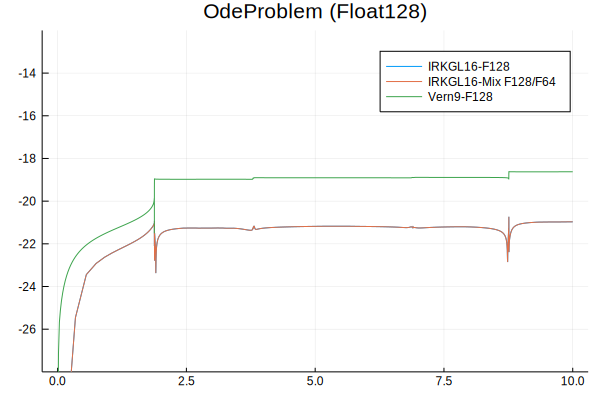

In [26]:
ylimit1=-28
ylimit2=-12
plot(title="Energy error (General ODE Problem)", xlabel="t", ylabel=L"\Delta E")
plot!(sol11.t,log10.(abs.(ΔE11)), label="IRKGL16-F128",
     ylims=(ylimit1,ylimit2),)
plot!(sol12.t,log10.(abs.(ΔE12)), label="IRKGL16-Mix F128/F64",
     ylims=(ylimit1,ylimit2),)
plot!(sol19.t,log10.(abs.(ΔE19)), label="Vern9-F128",
     ylims=(ylimit1,ylimit2),)

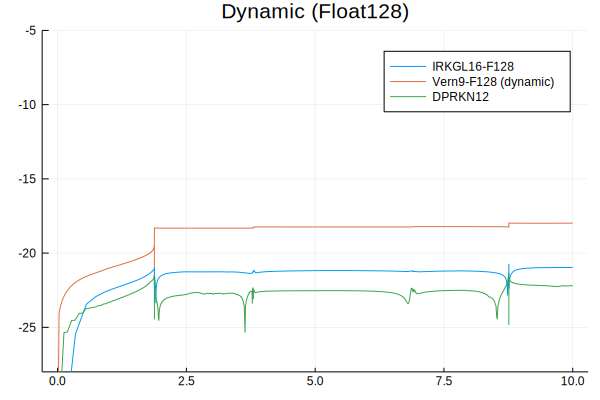

In [27]:
ylimit1=-28
ylimit2=-5
plot(title="Energy error (Second ODE Problem)", xlabel="t", ylabel=L"\Delta E")
plot!(sol21.t,log10.(abs.(ΔE21)), label="IRKGL16-F128",
     ylims=(ylimit1,ylimit2),)
plot!(sol29.t,log10.(abs.(ΔE29)), label="Vern9-F128 (dynamic) ",
     ylims=(ylimit1,ylimit2),)
plot!(sol28.t,log10.(abs.(ΔE28)), label="DPRKN12",
     ylims=(ylimit1,ylimit2),)

<a href="#top">Back to the top</a>